## 1. Data Preparation

### 1.1. Import Libraries

In [1]:
import numpy as np
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
import time

from sklearn.metrics import r2_score
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler  
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import GridSearchCV , KFold
from sklearn.metrics import mean_squared_error 
from sklearn.neighbors import KNeighborsRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.linear_model import Ridge , ElasticNet , Lasso
from sklearn.ensemble import RandomForestRegressor  , AdaBoostRegressor 
from sklearn.preprocessing import MinMaxScaler

- Import data, check for comlumns and variables
### 1.2. Load and Clean Data
Load the dataset, inspect its structure, and perform initial cleaning. We drop the original 'Price' column (in Toman) and use 'Price(USD)' for our analysis, renaming it to 'Price'.

In [2]:
houses = pd.read_csv("./data/housePrice.csv")
houses = houses.drop('Price', axis=1)
houses = houses.rename(columns={'Price(USD)': 'Price'})
houses.info()
houses.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3474 entries, 0 to 3473
Data columns (total 7 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   Area       3474 non-null   object 
 1   Room       3474 non-null   int64  
 2   Parking    3474 non-null   bool   
 3   Warehouse  3474 non-null   bool   
 4   Elevator   3474 non-null   bool   
 5   Address    3451 non-null   object 
 6   Price      3474 non-null   float64
dtypes: bool(3), float64(1), int64(1), object(2)
memory usage: 118.9+ KB


,Area,Room,Parking,Warehouse,Elevator,Address,Price
0,420,4,True,True,True,Zaferanieh,3080000.00
1,705,5,True,True,False,Abazar,3033333.33
2,400,5,True,True,False,Lavasan,2833333.33
3,680,5,True,True,False,Ekhtiarieh,2720000.00
4,350,4,True,True,True,Niavaran,2683333.33


- Since the Address column has some missing data in certain rows, we will drop these rows.

In [3]:
houses = houses.dropna(subset=['Address'])

- Check the header again

In [4]:
houses.info()

<class 'pandas.core.frame.DataFrame'>
Index: 3451 entries, 0 to 3473
Data columns (total 7 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   Area       3451 non-null   object 
 1   Room       3451 non-null   int64  
 2   Parking    3451 non-null   bool   
 3   Warehouse  3451 non-null   bool   
 4   Elevator   3451 non-null   bool   
 5   Address    3451 non-null   object 
 6   Price      3451 non-null   float64
dtypes: bool(3), float64(1), int64(1), object(2)
memory usage: 144.9+ KB


- Check the correlation between variables and the price variable before converting them into categories (actually this is feature engineering xD)

In [5]:
# houses['Price'] = np.log1p(houses['Price'])
# houses['Area'] = np.log1p(pd.to_numeric(houses['Area'], errors='coerce'))
houses['Area'] = pd.to_numeric(houses['Area'], errors='coerce')
houses = houses.dropna(subset=['Area'])
houses['Room'] = houses['Room'].astype('int64')
houses['Area_per_Room'] = houses['Area'] / (houses['Room']+1)
houses['Area_per_Room'] = houses['Area_per_Room'].replace([np.inf, -np.inf], np.nan)
address_avg_price = houses.groupby('Address')['Price'].mean()
houses['Avg_Price_by_Address'] = houses['Address'].map(address_avg_price)
houses['Price_per_m2'] = houses['Price'] / houses['Area']
address_avg_price_per_m2 = houses.groupby('Address')['Price_per_m2'].mean()
# houses['Avg_Price_per_m2_by_Address'] = houses['Address'].map(address_avg_price_per_m2)
houses = houses.drop('Price_per_m2', axis=1)

# houses['Parking_Warehouse'] = (houses['Parking'] == True) & (houses['Warehouse'] == True)
# houses['Parking_Elevator'] = (houses['Parking'] == True) & (houses['Elevator'] == True)
# houses['Elevator_Warehouse'] = (houses['Elevator'] == True) & (houses['Warehouse'] == True)
# houses['All_Amenities'] = (houses['Parking'] == True) & (houses['Warehouse'] == True) & (houses['Elevator'] == True)

numeric_houses = houses.select_dtypes(include=[np.number, bool]) 
corr_matrix = numeric_houses.corr()
corr_matrix["Price"].sort_values(ascending=False)

Price                   1.000000
Area                    0.722864
Avg_Price_by_Address    0.713365
Room                    0.567802
Area_per_Room           0.522454
Parking                 0.190935
Elevator                0.111443
Warehouse               0.109224
Name: Price, dtype: float64

- That said, the data is now complete. HOWEVER, we have not yet categorized the data into the two main types: Numerical and Categorical. Now, we will do that.

In [6]:
# Convert specified columns to categorical data type
houses['Room'] = houses['Room'].astype('category')
houses['Parking'] = houses['Parking'].astype('category')
houses['Warehouse'] = houses['Warehouse'].astype('category')
houses['Elevator'] = houses['Elevator'].astype('category')
# Verify the changes
print("Data types after conversion:")
print(houses.dtypes)
houses.info()

Data types after conversion:
Area                     float64
Room                    category
Parking                 category
Warehouse               category
Elevator                category
Address                   object
Price                    float64
Area_per_Room            float64
Avg_Price_by_Address     float64
dtype: object
<class 'pandas.core.frame.DataFrame'>
Index: 3449 entries, 0 to 3473
Data columns (total 9 columns):
 #   Column                Non-Null Count  Dtype   
---  ------                --------------  -----   
 0   Area                  3449 non-null   float64 
 1   Room                  3449 non-null   category
 2   Parking               3449 non-null   category
 3   Warehouse             3449 non-null   category
 4   Elevator              3449 non-null   category
 5   Address               3449 non-null   object  
 6   Price                 3449 non-null   float64 
 7   Area_per_Room         3449 non-null   float64 
 8   Avg_Price_by_Address  3449 non-nul

### 1.3. Outlier Removal
To prevent extreme values from skewing the analysis, we remove the top and bottom 1% of properties based on price.

In [7]:
# Calculate 1st and 99th percentiles
lower_percentile = houses['Price'].quantile(0.01)
upper_percentile = houses['Price'].quantile(0.97) # !!

price_min = lower_percentile
price_max = upper_percentile

print(price_max, price_min)

print(f"1st percentile (1% lowest): ${lower_percentile:.2f}")
print(f"99th percentile (1% highest): ${upper_percentile:.2f}")

# Remove outliers
houses_before = len(houses)
houses = houses[(houses['Price'] >= lower_percentile) & (houses['Price'] <= upper_percentile)]
houses_after = len(houses)

print(f"\nDataset size before removing outliers: {houses_before}")
print(f"Dataset size after removing outliers: {houses_after}")
print(f"Removed {houses_before - houses_after} outliers ({((houses_before - houses_after) / houses_before * 100):.1f}%)")

805599.9999999994 9865.3316
1st percentile (1% lowest): $9865.33
99th percentile (1% highest): $805600.00

Dataset size before removing outliers: 3449
Dataset size after removing outliers: 3310
Removed 139 outliers (4.0%)


## 2. Data Preparation


- first 10 rows

In [8]:
houses.head(10)

,Area,Room,Parking,Warehouse,Elevator,Address,Price,Area_per_Room,Avg_Price_by_Address
104,200.0,3,True,True,True,Zaferanieh,800000.00,50.00,785838.271481
105,320.0,4,True,True,True,Saadat Abad,800000.00,64.00,316291.989535
106,300.0,3,True,True,False,Golestan,800000.00,75.00,94322.916875
107,235.0,3,True,True,True,Gheitarieh,800000.00,58.75,357490.476429
108,235.0,3,True,True,True,Gheitarieh,800000.00,58.75,357490.476429
109,190.0,3,True,True,True,Aqdasieh,800000.00,47.50,585999.999600
110,210.0,3,True,True,True,Farmanieh,770000.00,52.50,697242.689825
111,210.0,4,True,True,False,Narmak,766666.67,42.00,131330.666800
112,232.0,3,True,True,True,Farmanieh,766666.67,58.00,697242.689825
113,230.0,3,True,True,True,Farmanieh,766666.67,57.50,697242.689825


- This part was already carried out in quite detail in the file `houses_price.ipynb`; you can refer to that notebook for more information.

- One-hot encoding

In [9]:
# One-hot encoding for Address column
address_encoded = pd.get_dummies(houses['Address'], prefix='Address')

# Concatenate the one-hot encoded columns with the original dataframe
houses_encoded = pd.concat([houses, address_encoded], axis=1)

# Drop the original Address column since we now have encoded versions
houses_encoded = houses_encoded.drop('Address', axis=1)

print(f"Original dataset shape: {houses.shape}")
print(f"Dataset shape after one-hot encoding: {houses_encoded.shape}")
print(f"Added {address_encoded.shape[1]} new columns for Address categories")

# Display the new column names
print(f"\nNew Address columns created:")
print(list(address_encoded.columns))

# Update our main dataframe
houses = houses_encoded
houses.head()

Original dataset shape: (3310, 9)
Dataset shape after one-hot encoding: (3310, 197)
Added 189 new columns for Address categories

New Address columns created:
['Address_Abazar', 'Address_Abbasabad', 'Address_Absard', 'Address_Abuzar', 'Address_Afsarieh', 'Address_Ahang', 'Address_Air force', 'Address_Ajudaniye', 'Address_Alborz Complex', 'Address_Aliabad South', 'Address_Amir Bahador', 'Address_Amirabad', 'Address_Amirieh', 'Address_Andisheh', 'Address_Aqdasieh', 'Address_Araj', 'Address_Argentina', 'Address_Atabak', 'Address_Azadshahr', 'Address_Azarbaijan', 'Address_Azari', 'Address_Baghestan', 'Address_Bahar', 'Address_Baqershahr', 'Address_Beryanak', 'Address_Boloorsazi', 'Address_Central Janatabad', 'Address_Chahardangeh', 'Address_Chardangeh', 'Address_Chardivari', 'Address_Chidz', 'Address_Damavand', 'Address_Darabad', 'Address_Darakeh', 'Address_Darband', 'Address_Daryan No', 'Address_Dehkade Olampic', 'Address_Dezashib', 'Address_Dolatabad', 'Address_Dorous', 'Address_East Fer

,Area,Room,Parking,Warehouse,Elevator,Price,Area_per_Room,Avg_Price_by_Address,Address_Abazar,Address_Abbasabad,...,Address_Waterfall,Address_West Ferdows Boulevard,Address_West Pars,Address_Yaftabad,Address_Yakhchiabad,Address_Yousef Abad,Address_Zafar,Address_Zaferanieh,Address_Zargandeh,Address_Zibadasht
104,200.0,3,True,True,True,800000.0,50.00,785838.271481,False,False,...,False,False,False,False,False,False,False,True,False,False
105,320.0,4,True,True,True,800000.0,64.00,316291.989535,False,False,...,False,False,False,False,False,False,False,False,False,False
106,300.0,3,True,True,False,800000.0,75.00,94322.916875,False,False,...,False,False,False,False,False,False,False,False,False,False
107,235.0,3,True,True,True,800000.0,58.75,357490.476429,False,False,...,False,False,False,False,False,False,False,False,False,False
108,235.0,3,True,True,True,800000.0,58.75,357490.476429,False,False,...,False,False,False,False,False,False,False,False,False,False


- Transform cols

In [10]:

X = houses.drop('Price', axis=1)  
y = houses['Price']              
print(f"Features shape: {X.shape}")
print(f"Target shape: {y.shape}")
print(f"\nFeature columns:")
print(list(X.columns))


X_train, X_test, y_train, y_test = train_test_split(
    X, y, 
    test_size=0.2,     
    random_state=42     
)

scaler_X = MinMaxScaler()

X_train_scaled = scaler_X.fit_transform(X_train)
X_test_scaled = scaler_X.transform(X_test)

X_train = pd.DataFrame(X_train_scaled, columns=X_train.columns, index=X_train.index)
X_test = pd.DataFrame(X_test_scaled, columns=X_test.columns, index=X_test.index)

scaler_y = MinMaxScaler()

y_train_reshaped = y_train.values.reshape(-1, 1)
y_test_reshaped = y_test.values.reshape(-1, 1)

y_train_scaled = scaler_y.fit_transform(y_train_reshaped)

y_test_scaled = scaler_y.transform(y_test_reshaped)

y_train = pd.Series(y_train_scaled.flatten(), name=y_train.name, index=y_train.index)
y_test = pd.Series(y_test_scaled.flatten(), name=y_test.name, index=y_test.index)

X_train.head()

Features shape: (3310, 196)
Target shape: (3310,)

Feature columns:
['Area', 'Room', 'Parking', 'Warehouse', 'Elevator', 'Area_per_Room', 'Avg_Price_by_Address', 'Address_Abazar', 'Address_Abbasabad', 'Address_Absard', 'Address_Abuzar', 'Address_Afsarieh', 'Address_Ahang', 'Address_Air force', 'Address_Ajudaniye', 'Address_Alborz Complex', 'Address_Aliabad South', 'Address_Amir Bahador', 'Address_Amirabad', 'Address_Amirieh', 'Address_Andisheh', 'Address_Aqdasieh', 'Address_Araj', 'Address_Argentina', 'Address_Atabak', 'Address_Azadshahr', 'Address_Azarbaijan', 'Address_Azari', 'Address_Baghestan', 'Address_Bahar', 'Address_Baqershahr', 'Address_Beryanak', 'Address_Boloorsazi', 'Address_Central Janatabad', 'Address_Chahardangeh', 'Address_Chardangeh', 'Address_Chardivari', 'Address_Chidz', 'Address_Damavand', 'Address_Darabad', 'Address_Darakeh', 'Address_Darband', 'Address_Daryan No', 'Address_Dehkade Olampic', 'Address_Dezashib', 'Address_Dolatabad', 'Address_Dorous', 'Address_East F

,Area,Room,Parking,Warehouse,Elevator,Area_per_Room,Avg_Price_by_Address,Address_Abazar,Address_Abbasabad,Address_Absard,...,Address_Waterfall,Address_West Ferdows Boulevard,Address_West Pars,Address_Yaftabad,Address_Yakhchiabad,Address_Yousef Abad,Address_Zafar,Address_Zaferanieh,Address_Zargandeh,Address_Zibadasht
2763,0.089655,0.4,1.0,1.0,0.0,0.107087,0.005917,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
173,0.181609,0.6,1.0,1.0,1.0,0.159055,0.222251,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3129,0.065517,0.4,1.0,1.0,1.0,0.074016,0.013589,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3020,0.087356,0.4,1.0,1.0,1.0,0.103937,0.013589,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2025,0.040230,0.4,1.0,1.0,1.0,0.039370,0.074898,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


## 3. Model training

- Split into test_set and train_set

In [11]:

print(f"\nTraining set:")
print(f"X_train shape: {X_train.shape}")
print(f"y_train shape: {y_train.shape}")

print(f"\nTesting set:")
print(f"X_test shape: {X_test.shape}")
print(f"y_test shape: {y_test.shape}")

print(f"\nData split summary:")
print(f"Total samples: {len(houses)}")
print(f"Training samples: {len(X_train)} ({len(X_train)/len(houses)*100:.1f}%)")
print(f"Testing samples: {len(X_test)} ({len(X_test)/len(houses)*100:.1f}%)")


Training set:
X_train shape: (2648, 196)
y_train shape: (2648,)

Testing set:
X_test shape: (662, 196)
y_test shape: (662,)

Data split summary:
Total samples: 3310
Training samples: 2648 (80.0%)
Testing samples: 662 (20.0%)


- try with models

- just convert function

In [12]:
price_min = scaler_y.data_min_[0]
price_max = scaler_y.data_max_[0]
def convert_scaled_to_original_price(scaled_value, price_min=None, price_max=None):
    """
    Convert scaled price value back to original USD price
    
    Parameters:
    scaled_value: float (0-1) - giá trị đã được MinMaxScaler
    price_min: float - giá trị min của Price sau khi log1p 
    price_max: float - giá trị max của Price sau khi log1p 
    
    Returns:
    float - giá trị USD gốc
    """
    
    # Bước 1: Unscale từ [0,1] về log scale
    log_price = scaled_value * (price_max - price_min) + price_min
    
    # Bước 2: Inverse log transform (expm1 là ngược lại của log1p)
    # original_price = np.expm1(log_price)
    original_price = log_price
    
    return original_price


In [13]:
from sklearn.model_selection import cross_val_score
from sklearn.pipeline import make_pipeline
import pandas as pd

models = {
    'Ridge Regression': Ridge(random_state=42),
    'Lasso Regression': Lasso(random_state=42),
    'ElasticNet': ElasticNet(random_state=42),
    'Decision Tree': DecisionTreeRegressor(random_state=42),
    'Random Forest': RandomForestRegressor(random_state=42),
    'K-Neighbors': KNeighborsRegressor(),
    'AdaBoost': AdaBoostRegressor(random_state=42)
}

# Store results
results = {}

print("Running K-Fold Cross Validation (k=10) for each model...")
print("=" * 60)

# Test each model with k-fold cross validation
for model_name, model in models.items():
    print(f"\nTesting {model_name}...")
    
    # Perform 10-fold cross validation
    # Using neg_root_mean_squared_error (negative RMSE)
    cv_scores = -cross_val_score(
        model, X_train, y_train,
        scoring="neg_root_mean_squared_error",
        cv=10,
        n_jobs=-1  # Use all available processors
    )
    
    # Store results
    results[model_name] = cv_scores
    
    # Display statistics
    score_stats = pd.Series(cv_scores).describe()
    print(f"Cross-validation RMSE scores for {model_name}:")
    print(score_stats)
    print(f"Mean RMSE: {cv_scores.mean():.6f} (+/- {cv_scores.std() * 2:.6f})")
    
    # Convert to original USD
    mean_rmse_usd = convert_scaled_to_original_price(cv_scores.mean(), price_min, price_max)
    print(f"Mean RMSE in original USD: ${mean_rmse_usd:,.2f}")

print("\n" + "=" * 60)
print("SUMMARY OF ALL MODELS")
print("=" * 60)

# Create summary comparison
summary_data = []
for model_name, scores in results.items():
    mean_rmse = scores.mean()
    mean_rmse_usd = convert_scaled_to_original_price(mean_rmse, price_min, price_max)
    
    summary_data.append({
        'Model': model_name,
        'Mean RMSE': mean_rmse,
        'Mean RMSE (USD)': mean_rmse_usd,
        'Std RMSE': scores.std(),
        'Min RMSE': scores.min(),
        'Max RMSE': scores.max()
    })

summary_df = pd.DataFrame(summary_data)
summary_df = summary_df.sort_values('Mean RMSE')

# Format the USD column for better display
summary_df_display = summary_df.copy()
summary_df_display['Mean RMSE (USD)'] = summary_df_display['Mean RMSE (USD)'].apply(lambda x: f"${x:,.2f}")

print(summary_df_display[['Model', 'Mean RMSE', 'Mean RMSE (USD)', 'Std RMSE']].to_string(index=False))

# Find the best model
best_model_name = summary_df.iloc[0]['Model']
best_rmse = summary_df.iloc[0]['Mean RMSE']
best_rmse_usd = summary_df.iloc[0]['Mean RMSE (USD)']

print(f"\nBest performing model: {best_model_name}")
print(f"Best RMSE: {best_rmse:.6f}")
print(f"Best RMSE in original USD: ${best_rmse_usd:,.2f}")

Running K-Fold Cross Validation (k=10) for each model...

Testing Ridge Regression...
Cross-validation RMSE scores for Ridge Regression:
count    10.000000
mean      0.085684
std       0.014379
min       0.068105
25%       0.073891
50%       0.085399
75%       0.092763
max       0.110251
dtype: float64
Mean RMSE: 0.085684 (+/- 0.027282)
Mean RMSE in original USD: $77,599.10

Testing Lasso Regression...
Cross-validation RMSE scores for Lasso Regression:
count    10.000000
mean      0.177629
std       0.015847
min       0.154478
25%       0.166754
50%       0.180222
75%       0.184227
max       0.210643
dtype: float64
Mean RMSE: 0.177629 (+/- 0.030067)
Mean RMSE in original USD: $150,244.29

Testing ElasticNet...
Cross-validation RMSE scores for ElasticNet:
count    10.000000
mean      0.177629
std       0.015847
min       0.154478
25%       0.166754
50%       0.180222
75%       0.184227
max       0.210643
dtype: float64
Mean RMSE: 0.177629 (+/- 0.030067)
Mean RMSE in original USD: $150,

In [14]:
best_model = RandomForestRegressor(random_state=42)
best_model.fit(X_train, y_train)

y_train_pred = best_model.predict(X_train)
y_test_pred = best_model.predict(X_test)

r2_train = r2_score(y_train, y_train_pred)
r2_test = r2_score(y_test, y_test_pred)

rmse_train = np.sqrt(mean_squared_error(y_train, y_train_pred))
rmse_test = np.sqrt(mean_squared_error(y_test, y_test_pred))

rmse_train_usd = convert_scaled_to_original_price(rmse_train, price_min, price_max)
rmse_test_usd = convert_scaled_to_original_price(rmse_test, price_min, price_max)

print("Random Forest Model Performance:")
print("=" * 50)
print(f"Training Set:")
print(f"  R² Score: {r2_train:.6f}")
print(f"  RMSE: {rmse_train:.6f}")
print(f"  RMSE (USD): ${rmse_train_usd:,.2f}")

print(f"\nTest Set:")
print(f"  R² Score: {r2_test:.6f}")
print(f"  RMSE: {rmse_test:.6f}")
print(f"  RMSE (USD): ${rmse_test_usd:,.2f}")

print(f"\nModel Comparison:")
print(f"  Difference in R² (Train - Test): {r2_train - r2_test:.6f}")
print(f"  Difference in RMSE (Test - Train): {rmse_test - rmse_train:.6f}")

if r2_train - r2_test > 0.1:
    print("Potential overfitting detected (R² difference > 0.1)")
else:
    print("Good generalization performance")

Random Forest Model Performance:
Training Set:
  R² Score: 0.967608
  RMSE: 0.032067
  RMSE (USD): $35,235.98

Test Set:
  R² Score: 0.881473
  RMSE: 0.066190
  RMSE (USD): $62,196.58

Model Comparison:
  Difference in R² (Train - Test): 0.086135
  Difference in RMSE (Test - Train): 0.034123
Good generalization performance


In [15]:
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from scipy.stats import randint, uniform

# Define parameter grid for GridSearchCV (optimized for ~1000-2000 runs)
param_grid = {
    'n_estimators': [100, 200, 300],          # 3 values (reduced from 4)
    'max_features': ['sqrt', 'log2'],         # 2 values (removed None)
    'max_depth': [10, 15, 20, None],         # 4 values (reduced from 5)
    'min_samples_split': [2, 5, 10],         # 3 values (reduced from 4)
    'min_samples_leaf': [1, 2, 4],           # 3 values (reduced from 4)
    'bootstrap': [True, False]                # 2 values (kept same)
}

# Calculate total combinations
total_combinations = 1
for param, values in param_grid.items():
    total_combinations *= len(values)
print(f"Total parameter combinations to test: {total_combinations:,}")
print(f"With 5-fold CV, total fits: {total_combinations * 5:,}")

# Create GridSearchCV
grid_search = GridSearchCV(
    RandomForestRegressor(random_state=42),
    param_grid=param_grid,
    cv=5,        # 5-fold cross validation
    scoring='neg_root_mean_squared_error',
    n_jobs=-1,   # Use all available processors
    verbose=1    # Show progress
)

print("Starting Grid Search CV...")
print("This will test ALL parameter combinations - may take a while...")
start_time = time.time()

# Fit the grid search
grid_search.fit(X_train, y_train)

end_time = time.time()
print(f"Grid Search completed in {end_time - start_time:.2f} seconds")
print(f"Time per combination: {(end_time - start_time) / total_combinations:.2f} seconds")

# Get the best parameters and score
print("\nBest parameters found:")
print(grid_search.best_params_)
print(f"\nBest cross-validation RMSE: {-grid_search.best_score_:.6f}")
print(f"Best RMSE in USD: ${convert_scaled_to_original_price(-grid_search.best_score_, price_min, price_max):,.2f}")

# Train the best model on full training set and evaluate
best_rf_model = grid_search.best_estimator_
y_train_pred_best = best_rf_model.predict(X_train)
y_test_pred_best = best_rf_model.predict(X_test)

# Calculate performance metrics
r2_train_best = r2_score(y_train, y_train_pred_best)
r2_test_best = r2_score(y_test, y_test_pred_best)
rmse_train_best = np.sqrt(mean_squared_error(y_train, y_train_pred_best))
rmse_test_best = np.sqrt(mean_squared_error(y_test, y_test_pred_best))

print(f"\nOptimized Random Forest Performance:")
print(f"Training R²: {r2_train_best:.6f}")
print(f"Test R²: {r2_test_best:.6f}")
print(f"Training RMSE: {rmse_train_best:.6f} (${convert_scaled_to_original_price(rmse_train_best, price_min, price_max):,.2f})")
print(f"Test RMSE: {rmse_test_best:.6f} (${convert_scaled_to_original_price(rmse_test_best, price_min, price_max):,.2f})")

# Compare with original model
print(f"\nComparison with original Random Forest:")
print(f"Original Test RMSE: {rmse_test:.6f} vs Optimized: {rmse_test_best:.6f}")
print(f"Improvement: {((rmse_test - rmse_test_best) / rmse_test * 100):.2f}%")

# Show top 10 parameter combinations
print(f"\nTop 10 parameter combinations:")
print("="*80)
results_df = pd.DataFrame(grid_search.cv_results_)
top_10 = results_df.nlargest(10, 'mean_test_score')[['params', 'mean_test_score', 'std_test_score']]
for i, (idx, row) in enumerate(top_10.iterrows(), 1):
    rmse = -row['mean_test_score']
    rmse_usd = convert_scaled_to_original_price(rmse, price_min, price_max)
    print(f"{i:2d}. RMSE: {rmse:.6f} (${rmse_usd:,.0f}) | {row['params']}")

Total parameter combinations to test: 432
With 5-fold CV, total fits: 2,160
Starting Grid Search CV...
This will test ALL parameter combinations - may take a while...
Fitting 5 folds for each of 432 candidates, totalling 2160 fits


Grid Search completed in 365.64 seconds
Time per combination: 0.85 seconds

Best parameters found:
{'bootstrap': True, 'max_depth': None, 'max_features': 'sqrt', 'min_samples_leaf': 1, 'min_samples_split': 10, 'n_estimators': 300}

Best cross-validation RMSE: 0.067348
Best RMSE in USD: $63,111.36

Optimized Random Forest Performance:
Training R²: 0.924889
Test R²: 0.892649
Training RMSE: 0.048830 ($48,480.75)
Test RMSE: 0.062992 ($59,669.91)

Comparison with original Random Forest:
Original Test RMSE: 0.066190 vs Optimized: 0.062992
Improvement: 4.83%

Top 10 parameter combinations:
 1. RMSE: 0.067348 ($63,111) | {'bootstrap': True, 'max_depth': None, 'max_features': 'sqrt', 'min_samples_leaf': 1, 'min_samples_split': 10, 'n_estimators': 300}
 2. RMSE: 0.067399 ($63,152) | {'bootstrap': True, 'max_depth': None, 'max_features': 'sqrt', 'min_samples_leaf': 1, 'min_samples_split': 10, 'n_estimators': 200}
 3. RMSE: 0.067693 ($63,384) | {'bootstrap': True, 'max_depth': None, 'max_features'

## 4. EDA test

9900.0
800000.0
Sample of original prices:
[625000.   218333.33 113333.33 125333.33 433333.33]

Sample of predicted prices:
[536174.26340858 161463.05856511 181313.92743033 105298.9397639
 409879.49463591]
Total test samples: 662
Predictions with error > 20%: 220 (33.2%)
Mean percentage error: 25.58%
Median percentage error: 12.40%


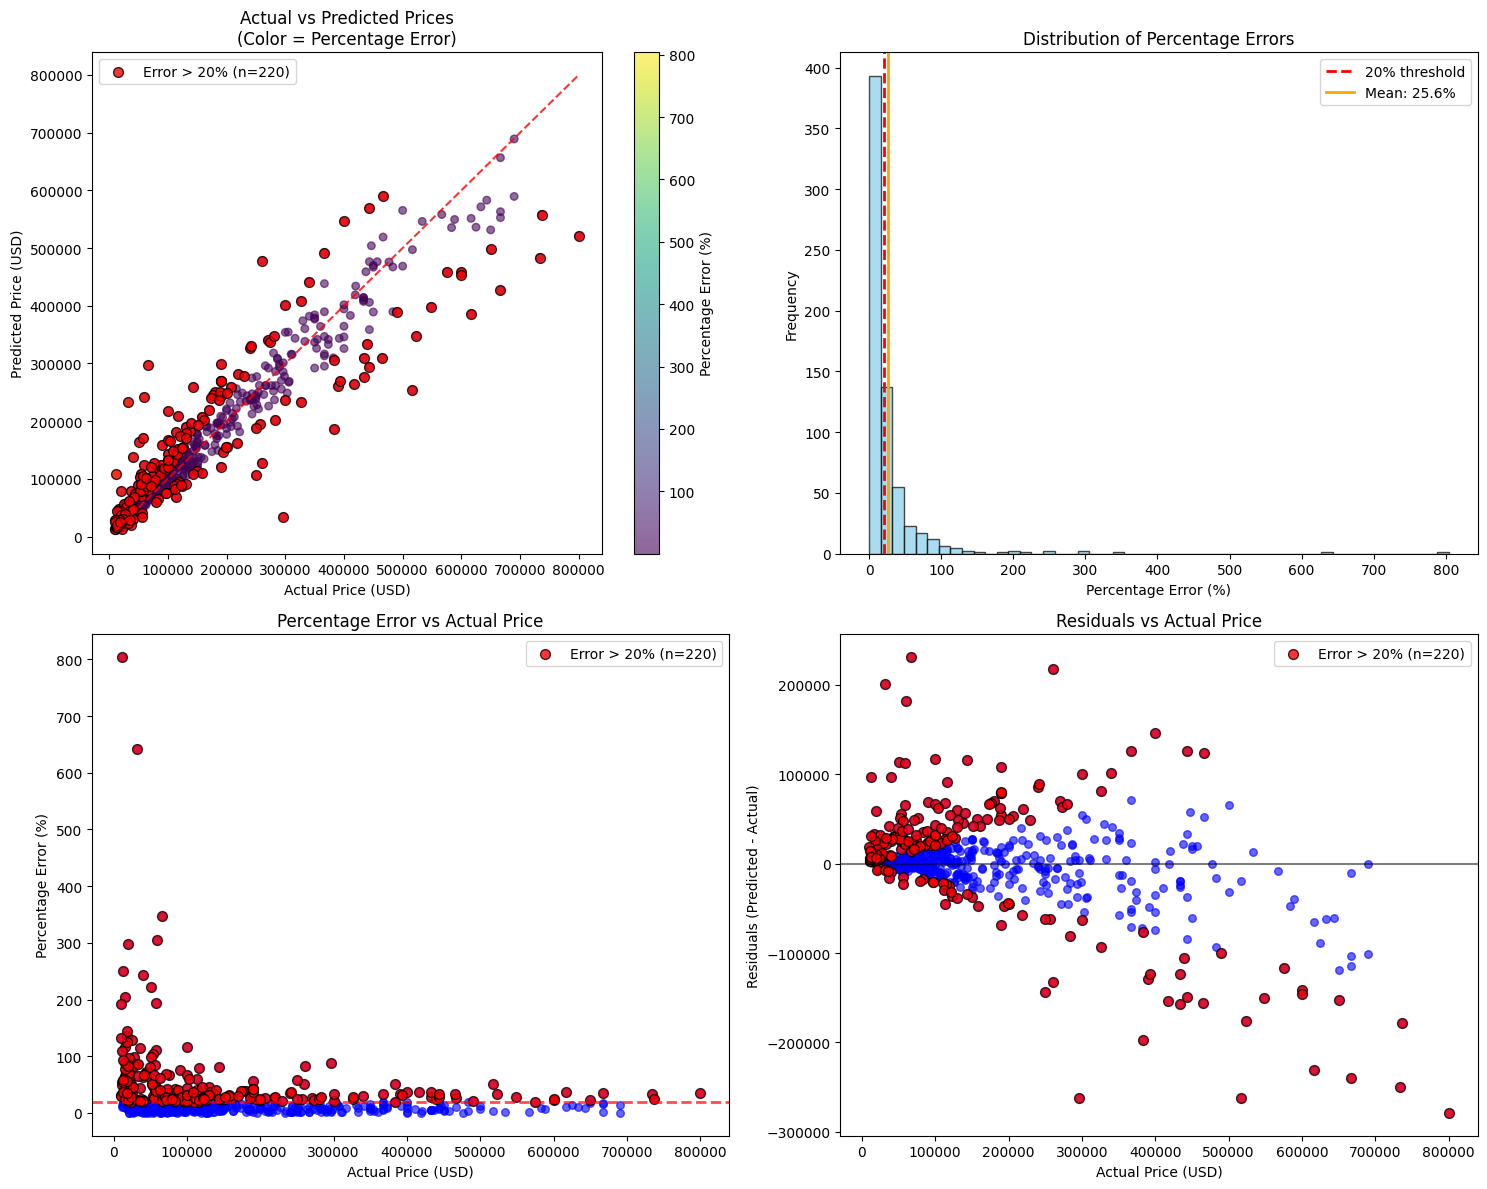


Top 10 worst predictions (highest percentage errors):
 1. Actual: $  12,000 | Predicted: $ 108,480 | Error: 804.0%
 2. Actual: $  31,333 | Predicted: $ 232,644 | Error: 642.5%
 3. Actual: $  66,667 | Predicted: $ 297,830 | Error: 346.7%
 4. Actual: $  59,733 | Predicted: $ 242,064 | Error: 305.2%
 5. Actual: $  19,833 | Predicted: $  78,875 | Error: 297.7%
 6. Actual: $  12,500 | Predicted: $  43,742 | Error: 249.9%
 7. Actual: $  40,000 | Predicted: $ 137,409 | Error: 243.5%
 8. Actual: $  51,200 | Predicted: $ 164,504 | Error: 221.3%
 9. Actual: $  16,000 | Predicted: $  48,635 | Error: 204.0%
10. Actual: $  58,333 | Predicted: $ 171,505 | Error: 194.0%


In [16]:
print(price_min)
print(price_max)

# Calculate percentage errors for the optimized Random Forest model
y_test_original = scaler_y.inverse_transform(y_test.values.reshape(-1, 1)).flatten()
y_test_pred_original = scaler_y.inverse_transform(y_test_pred_best.reshape(-1, 1)).flatten()

print("Sample of original prices:")
print(y_test_original[:5])
print("\nSample of predicted prices:")
print(y_test_pred_original[:5])

# Calculate percentage error
percentage_errors = np.abs((y_test_pred_original - y_test_original) / y_test_original) * 100

# Identify predictions with error > 20%
high_error_mask = percentage_errors > 20
high_error_indices = np.where(high_error_mask)[0]

print(f"Total test samples: {len(y_test)}")
print(f"Predictions with error > 20%: {np.sum(high_error_mask)} ({np.sum(high_error_mask)/len(y_test)*100:.1f}%)")
print(f"Mean percentage error: {percentage_errors.mean():.2f}%")
print(f"Median percentage error: {np.median(percentage_errors):.2f}%")

# Create visualization
fig, axes = plt.subplots(2, 2, figsize=(15, 12))

# 1. Scatter plot: Actual vs Predicted prices
ax1 = axes[0, 0]
scatter = ax1.scatter(y_test_original, y_test_pred_original, 
                     c=percentage_errors, cmap='viridis', alpha=0.6, s=30)
ax1.plot([y_test_original.min(), y_test_original.max()], 
         [y_test_original.min(), y_test_original.max()], 'r--', alpha=0.8)
ax1.set_xlabel('Actual Price (USD)')
ax1.set_ylabel('Predicted Price (USD)')
ax1.set_title('Actual vs Predicted Prices\n(Color = Percentage Error)')
plt.colorbar(scatter, ax=ax1, label='Percentage Error (%)')

# Highlight high error points
high_error_actual = y_test_original[high_error_mask]
high_error_pred = y_test_pred_original[high_error_mask]
ax1.scatter(high_error_actual, high_error_pred, color='red', s=50, alpha=0.8, 
           edgecolors='black', linewidth=1, label=f'Error > 20% (n={len(high_error_actual)})')
ax1.legend()

# 2. Distribution of percentage errors
ax2 = axes[0, 1]
ax2.hist(percentage_errors, bins=50, alpha=0.7, color='skyblue', edgecolor='black')
ax2.axvline(x=20, color='red', linestyle='--', linewidth=2, label='20% threshold')
ax2.axvline(x=percentage_errors.mean(), color='orange', linestyle='-', linewidth=2, 
           label=f'Mean: {percentage_errors.mean():.1f}%')
ax2.set_xlabel('Percentage Error (%)')
ax2.set_ylabel('Frequency')
ax2.set_title('Distribution of Percentage Errors')
ax2.legend()

# 3. Error vs Actual Price
ax3 = axes[1, 0]
ax3.scatter(y_test_original, percentage_errors, alpha=0.6, s=30, color='blue')
ax3.scatter(y_test_original[high_error_mask], percentage_errors[high_error_mask], 
           color='red', s=50, alpha=0.8, edgecolors='black', linewidth=1,
           label=f'Error > 20% (n={np.sum(high_error_mask)})')
ax3.axhline(y=20, color='red', linestyle='--', linewidth=2, alpha=0.7)
ax3.set_xlabel('Actual Price (USD)')
ax3.set_ylabel('Percentage Error (%)')
ax3.set_title('Percentage Error vs Actual Price')
ax3.legend()

# 4. Residuals plot
ax4 = axes[1, 1]
residuals = y_test_pred_original - y_test_original
ax4.scatter(y_test_original, residuals, alpha=0.6, s=30, color='blue')
ax4.scatter(y_test_original[high_error_mask], residuals[high_error_mask], 
           color='red', s=50, alpha=0.8, edgecolors='black', linewidth=1,
           label=f'Error > 20% (n={np.sum(high_error_mask)})')
ax4.axhline(y=0, color='black', linestyle='-', alpha=0.5)
ax4.set_xlabel('Actual Price (USD)')
ax4.set_ylabel('Residuals (Predicted - Actual)')
ax4.set_title('Residuals vs Actual Price')
ax4.legend()

plt.tight_layout()
plt.show()

# Show details of worst predictions
print(f"\nTop 10 worst predictions (highest percentage errors):")
print("="*80)
worst_indices = np.argsort(percentage_errors)[-10:][::-1]
for i, idx in enumerate(worst_indices, 1):
    actual = y_test_original[idx]
    predicted = y_test_pred_original[idx]
    error = percentage_errors[idx]
    print(f"{i:2d}. Actual: ${actual:8,.0f} | Predicted: ${predicted:8,.0f} | Error: {error:5.1f}%")